# pyheatmy Demo Notebook

This notebook aims to present the various features of `pyheatmy`. It explains how to:
- create a `Column` object from an easy reading of dates
- execute the direct model, for homogeneous (section 2)  and heterogeneous (section 3) riverbeds
- execute the MCMC
- retrieve and display the various results produced during the executions of the direct model or the MCMC

This notebook doesn't provide yet information on the DREAM method implemented in 2023. For that purpose please refer to the `DREAM_VX.ipynb` notebooks

`pyheatmy` is built around the monolithic `Column` class in `core.py`. It can be executed from this class. Calculation, data retrieval, and plotting are methods provided by the `Column` class.

It is based on real data, which can be found in the `data` folder.

We recommend reading the API for more details. 

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



Parametres(moinslog10IntrinK=11, n=0.1, lambda_s=2, rhos_cs=4000000.0, q=0)


## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("./data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("./data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("./configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

print(f"dH : {dH_measures}")
print(f"Tshaft : {T_measures}")


dH : [(Timestamp('2016-06-28 06:45:00'), (0.8455651738980304, 287.16499999999996)), (Timestamp('2016-06-28 07:00:00'), (0.845598722046913, 287.159)), (Timestamp('2016-06-28 07:15:00'), (0.84563866885015, 287.15799999999996)), (Timestamp('2016-06-28 07:30:00'), (0.8456745294855709, 287.15599999999995)), (Timestamp('2016-06-28 07:45:00'), (0.8457087531923185, 287.15599999999995)), (Timestamp('2016-06-28 08:00:00'), (0.8457346869561947, 287.15599999999995)), (Timestamp('2016-06-28 08:15:00'), (0.8457538391584245, 287.161)), (Timestamp('2016-06-28 08:30:00'), (0.8457628039753982, 287.167)), (Timestamp('2016-06-28 08:45:00'), (0.8457635267129118, 287.174)), (Timestamp('2016-06-28 09:00:00'), (0.8457572935292086, 287.179)), (Timestamp('2016-06-28 09:15:00'), (0.8457517700915217, 287.185)), (Timestamp('2016-06-28 09:30:00'), (0.8457492408521055, 287.19399999999996)), (Timestamp('2016-06-28 09:45:00'), (0.8457605113179875, 287.21799999999996)), (Timestamp('2016-06-28 10:00:00'), (0.84577645940

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [5]:
Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

## 2. Colonne homogène

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Modèle direct

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [11]:
moinslog10IntrinK = 11
n = .1
lambda_s = 2
rhos_cs = 4e6
q = 0
params = Param(moinslog10IntrinK,n,lambda_s,rhos_cs,q)

# assert params == params_tuple

Puis on appelle le modèle direct :

In [12]:
col.compute_solve_transi(params,verbose=False)

Et on utilise les méthodes de récupération des résultats et de tracer

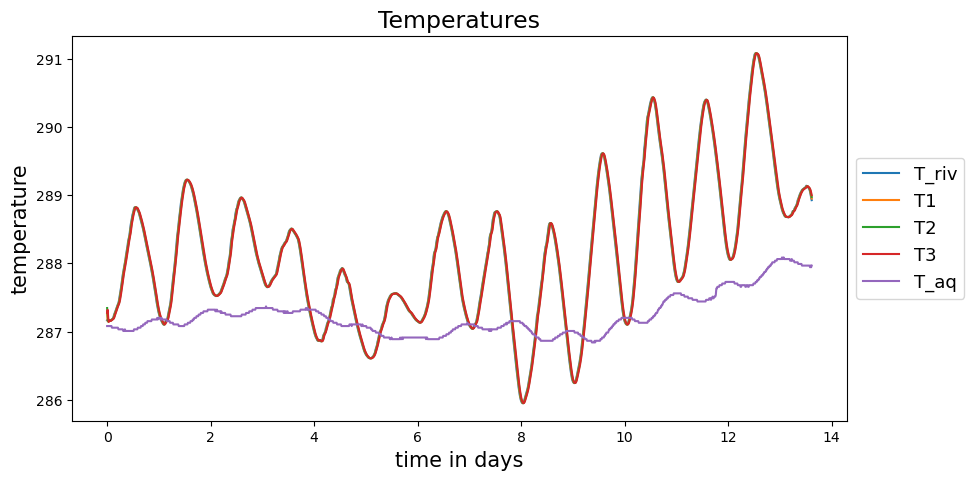

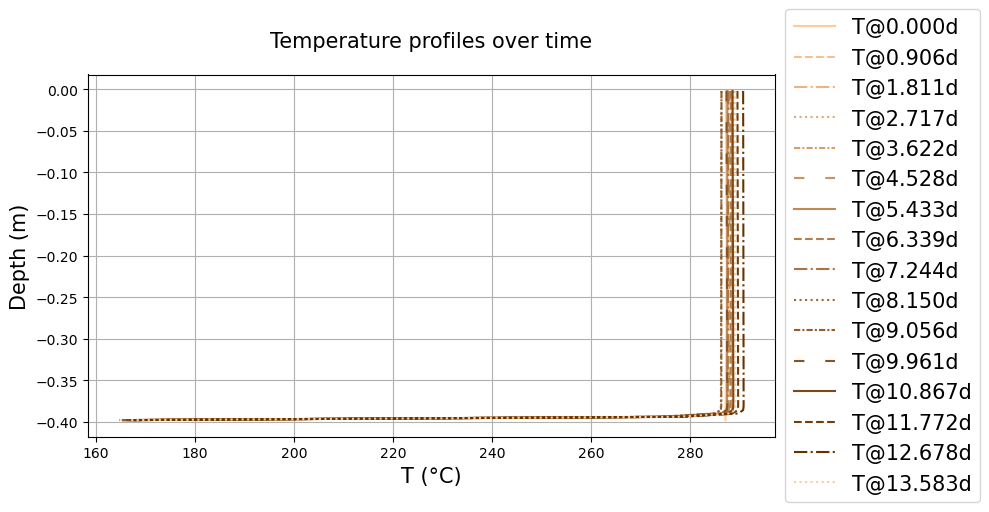

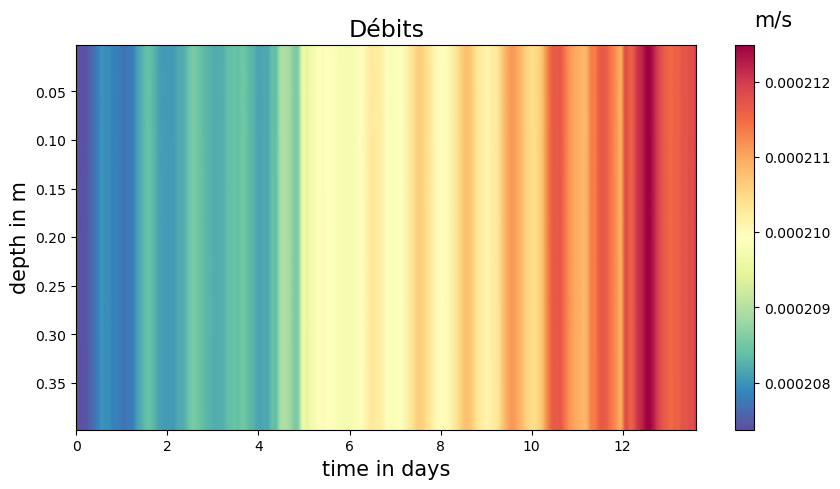

In [13]:
col.plot_temperature_at_sensors()

nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))

flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

Calcul des écarts de température et comparaison des températures simulées et observées

RMSE at sensor 0 : 0.6471907582394485
RMSE at sensor 1 : 1.5523001667522571
RMSE at sensor 2 : 1.089233172133397
Total RMSE : 1.1568521352540293


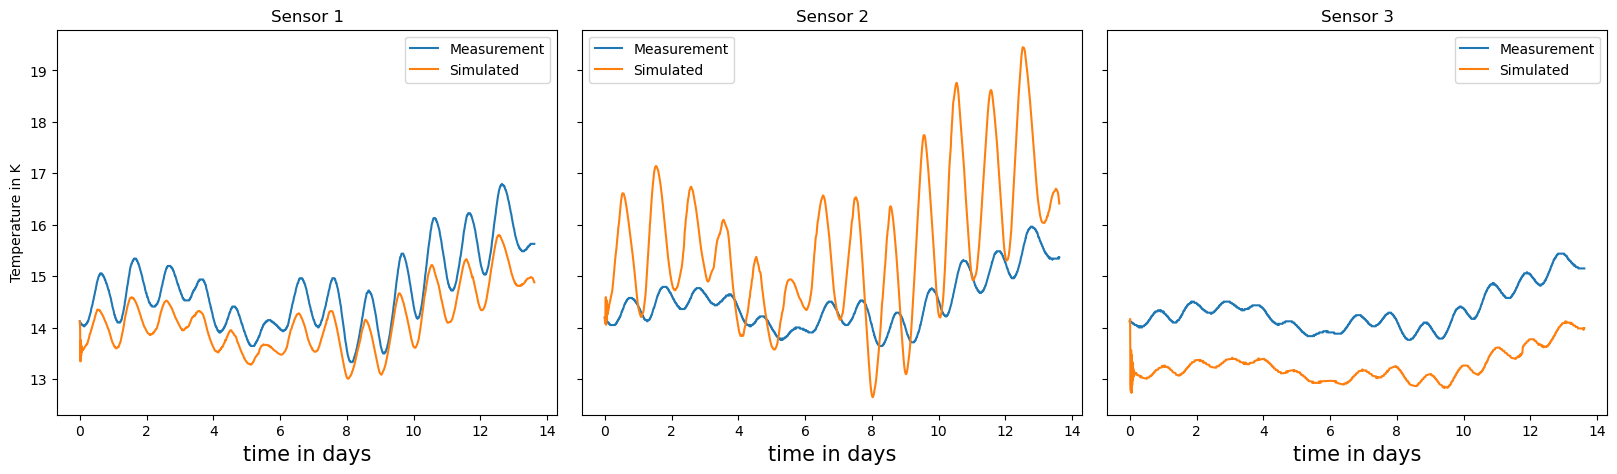

In [9]:
col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()

The simulations are of very pour quality. Let's inverse the data with mcmc

### 2.2 Bayesian inversion

In [10]:
priors = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

all_priors = [
    ['Couche 1', Zbottom, priors],
]
col.compute_mcmc(
    nb_iter = 300,
    all_priors = all_priors,
    nb_cells = 100,
    sigma2=1.0,
    verbose=False
)

bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers, nb_cells=100,verbose=False)
col.plot_all_results()

TypeError: Column.compute_mcmc() got an unexpected keyword argument 'nb_cells'


### 2.3 Quantiles

Une MCMC calcule aussi des quantiles de températures et de débits d'eau. On peut les récupérer de la façon suivante :

In [ ]:
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()
    

On peut aussi regarder les quantiles au niveau des capteurs, et comparer avec les mesures :

## 3. Multilayer Column

### 3.1. Direct Model

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

In [ ]:
from pyheatmy.layers import layersListCreator

moinslog10IntrinK = 11
deltaK = 4
Zinterface = 0.2
layers_list = layersListCreator([("Couche 1", Zinterface, moinslog10IntrinK, n, lambda_s, rhos_cs), ("Couche 2", Zbottom, moinslog10IntrinK+deltaK, n, lambda_s, rhos_cs)])

Puis on appelle le modèle direct :

In [ ]:
col.compute_solve_transi(layers_list, nb_cells=100,verbose=False)

col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()
col.plot_temperature_at_sensors()
nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))
flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

## 3.2 Inférence bayésienne

L'inférence bayésienne va nous permettre d'estimer une distribution a posteriori pour chaque paramètre.

### 3.2.1. MCMC sans estimation de l'erreur

On peut lancer une MCMC en gardant $\sigma^2$ constant. On définit des distributions a priori pour chaque couche :

In [ ]:
priors_couche_1 = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

priors_couche_2 = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
}

all_priors = [
    ['Couche 1', Zinterface, priors_couche_1],
    ['Couche 2', Zbottom, priors_couche_2],
]

col.compute_mcmc(
    nb_iter = 400,
    all_priors = all_priors,
    nb_cells = 100,
    sigma2=1.0,
    verbose=False
)

#### Recupération et affichage des distributions

In [ ]:
col.plot_all_param_pdf()


In [ ]:
bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers, nb_cells=100,verbose=False)
col.plot_all_results()
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

#### Options : Récupération d'autres paramètres
Voici les un exemple de paramètres qui, normalement, sont bons :

In [ ]:
otherGoodLayers = layersListCreator([("Couche 1", 0.20, 7.915378861204348, 0.1310721719612464, 5.602951622531522, 4758163.582292321),
("Couche 2", 0.40, 6.574103692603533, 0.029547616319484868, 3.944439207155854, 4931216.13398901)])

#### 3.2.3 MCMC avec estimation de l'erreur

Pour lancer une MCMC avec estimation de la distribution de $\sigma^2$, il suffit d'ajouter une distribution a priori sur ce paramètre. On utilise pour cela la classe ``Prior``, qui est initialisée avec :
- un tuple pour l'intervalle dans lequel le paramètre varie
- un écart type pour la marche aléatoire
- une densité

In [ ]:
sigma_prior = Prior((0.1, np.inf), 0.1, lambda x : 1/x)

col.compute_mcmc(
    nb_iter = 400,
    all_priors = all_priors,
    nb_cells = 100,
    sigma2_temp_prior = sigma_prior,
    verbose=False
)

bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers, nb_cells=100,verbose=False)
col.plot_all_param_pdf()
col.plot_all_results()
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()